In [41]:
from tst.domutil.util import *
from tst.domutil.test import *
import sys
reload(sys.modules["tst.domutil.util"])
from tst.domutil.util import *
reload(sys.modules["tst.domutil.test"])
from tst.domutil.test import *

In [3]:
%%time
##############################################################
### Fetch MySQL and cache data into Python lists   ###########
##############################################################

# print "finished"
hmms = HMMprofile.objects.defer('text').all().prefetch_related('hits')
hmms = hmms.annotate(hcount = Count('hits')).order_by('id')

# hmmids = list(hmms.values_list('id',flat = True))
hcounts = list(hmms.values_list('hcount',flat = True))
sfs = list(hmms.values_list('cath_node__parent',flat = True))

# sDB = seqDB.objects.get(name = 'CATH')
# sDB.sequence_set.count()
# seq = sDB.sequence_set.first()

# seqset_all = sDB.sequence_set.all().prefetch_related('hmmprofile_set')

# # seq.HMMprofile
# # seq.hmmprofile
# # dir(seq)
# seq.hmmprofile_set.count()

# hcounts_pad = hcounts_
# hmmids_pad = hmmids[:]
# hmmids_pad.insert(0, None)

hcounts_pad = hcounts[:]
hcounts_pad.insert(0,None)

# sfs_pad = sfs[:]
# sfs_pad.insert(0,None)

CPU times: user 40 ms, sys: 8 ms, total: 48 ms
Wall time: 44.9 s


In [2]:
%%time
D_raw = pk_load('D_raw')
D_norm = pk_load('D_norm')
# D_raw = pk_load('H_D_raw')
# D_norm = pk_load('H_D_norm')

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 221 ms


In [25]:
test__raw( D_raw,hmms)
test__norm(D_norm, hmms, ISS_normalise_new)

[OK] HMM for 3.40.50.720.379.0  against HMM for 3.40.50.720.491.0  overlaps 3, with 3 from 
0 of -1
[OK] HMM for 3.40.30.10.192.0  against HMM for 3.40.30.10.217.0  overlaps 326, with 326 from 
[OK] HMM for 3.40.50.300.138.0  against HMM for 3.40.50.2300.249.0  overlaps 9, with 9 from 
[OK] HMM for 3.55.50.10.1.0  against HMM for 3.40.50.720.359.0  overlaps 4, with 4 from 
[OK] HMM for 3.20.20.210.2.0  against HMM for 3.20.20.140.5.0  overlaps 1, with 1 from 
[OK] HMM for 3.40.50.720.379.0  against HMM for 3.40.50.720.491.0  overlaps:: Expected:0.227541855883, Actual:0.227541855883
0 of -1
[OK] HMM for 3.40.30.10.192.0  against HMM for 3.40.30.10.217.0  overlaps:: Expected:0.977196899386, Actual:0.977196899386
[OK] HMM for 3.40.50.300.138.0  against HMM for 3.40.50.2300.249.0  overlaps:: Expected:0.388674527682, Actual:0.388674527682
[OK] HMM for 2.60.40.10.693.0  against HMM for 2.60.40.420.36.0  overlaps:: Expected:0.27865376681, Actual:0.27865376681
[OK] HMM for 3.55.50.10.1.0  agai

In [5]:
%%time
sfs = list(hmms.values_list('cath_node__parent',flat = True))

dct = classification.objects.in_bulk(sfs)
sf_db = [None] + [ dct[x] for x in sfs]
sfs_db = [dct[sfi] for sfi in sfs]

topo_db =  [x.parent if x else None for x in sf_db   ]
arch_db =  [x.parent if x else None for x in topo_db ]
class_db = [x.parent if x else None for x in arch_db ]

CPU times: user 3.88 s, sys: 112 ms, total: 4 s
Wall time: 5.49 s


In [29]:
%%time
##################################################################
##################################################################
############### Append information to pairwise hits   ############
######## Calculate hierarchial information for histogram #########
##################################################################
##################################################################

# using_coo_izip
# D_curr = D_raw
D_curr = D_norm

xdata = []
ydata = []
vdata = []
sfbools = []
topobools = []
archbools = []
classbools = []

for x,y,v in using_tocoo_izip(D_curr):
    xdata.append(x)
    ydata.append(y)
    vdata.append(v)
    
    sameclass = class_db[x] == class_db[y]
    if sameclass:
        samearch = arch_db[x] == arch_db[y]
    else:
        samearch = False        
    if samearch:
        sametopo = topo_db[x] == topo_db[y]
    else:
        sametopo = False    
    if sametopo:
        samesf   = sf_db[x] == sf_db[y]
    else:
        samesf   = False

    classbools.append ( sameclass )
    archbools. append ( samearch )
    topobools. append ( sametopo )
    sfbools.   append ( samesf )


CPU times: user 27.3 s, sys: 284 ms, total: 27.6 s
Wall time: 27.4 s


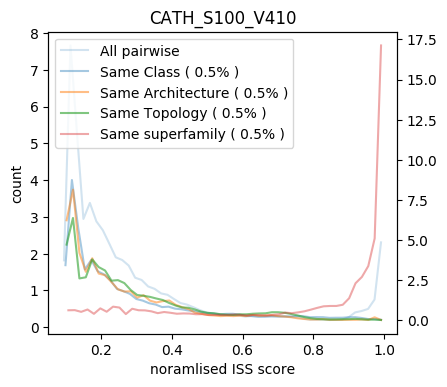

In [40]:
import matplotlib
%matplotlib inline
matplotlib.use("Agg")
from matplotlib import pyplot as plt
from scipy import stats
# from mpl_toolkits.mplot3d import Axes3D
# kwargs = {
#     'projection':'3d',
# }


vals0 = np.array(vdata)
# vals0 = vals0/(1.01-vals0) 
# vals0 = np.log(vals0)

kwargs = {'ylabel':'count',
          'xlabel':'noramlised ISS score',
         'title':'CATH_S100_V410',
         }
plt.close()
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
ax1b = ax1.twinx()

# ax1.set_yscale('log')
# ax1.set_xscale('log')
# vals = np.maximum(0,vdata)
# lbls = [None]



lbl = 'All pairwise'
kargs = {'label':lbl}


vals = np.ma.array(vals0,mask = None)

ys,binEdges = np.histogram(vals,bins=50, 
                          density = True
                          )%%time
D_raw = pk_load('H_D_raw')
D_norm = pk_load('H_D_norm')
rdict, hcounts = pk_load('H_meta')
bincenters  = 0.5*( binEdges[1:] + binEdges[:-1] )

ax1.plot( bincenters, ys, '-' ,

# binsA1 = ax1.hist( vals,100, 
#     facecolor = 'b',

# edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.2,
     **kargs
#     label = ''
     )



lbl = 'Same Class ( 0.5% )'
kargs = {'label': lbl}
vals = vals0[ listANDNOT(classbools,archbools)]

ys,binEdges = np.histogram(vals,bins=50, 
                          density = True
                          )
bincenters  = 0.5 * ( binEdges[1:] + binEdges[:-1] )

ax1b.plot( bincenters, ys, '-' ,
# binsB1 = ax1b.hist( vals,100, 
#     facecolor = 'g',
     alpha = 0.4,
     **kargs
     )





lbl = 'Same Architecture ( 0.5% )'
kargs = {'label': lbl}
vals = vals0[listANDNOT(archbools, topobools)]


ys,binEdges = np.histogram(vals,bins=50,
                          density = True
                          )
bincenters  = 0.5*( binEdges[1:] + binEdges[:-1] )

ax1b.plot( bincenters, ys, '-' ,

# binsB1 = ax1b.hist( vals,100, 
#     facecolor = 'g',

    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.5,
     **kargs
     )




lbl = 'Same Topology ( 0.5% )'
kargs = { 'label': lbl }
vals = vals0[listANDNOT(topobools,sfbools)]

ys,binEdges = np.histogram(vals,bins=50, 
                          density = True
                          )
bincenters  = 0.5*( binEdges[1:] + binEdges[:-1] )

ax1b.plot( bincenters, ys, '-' ,

# binsB1 = ax1b.hist( vals,100, 
#     facecolor = 'g',
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.6,
     **kargs
     )






lbl = 'Same superfamily ( 0.5% )'
kargs = {'label': lbl}
vals = vals0[sfbools]

ys,binEdges = np.histogram(vals,bins=50, 
                          density = True
                          )
bincenters  = 0.5*( binEdges[1:] + binEdges[:-1] )

ax1b.plot( bincenters, ys, '-' ,

# binsB1 = ax1b.hist( vals,100, 
#     facecolor = 'r',
         
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.4,
     **kargs
     )






lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()

ax1.legend(lines + lines2,
           labels + labels2,
           loc = 2)

# ax1b.set_ylim( [-.2, 2] )
# ax1b.set_ylim( [-.2, 1] )

# ax1b.set_ylim( [0,0.005] )


# # vals = np
# ax1.legend( )
# ax1b.legend( )
# ax1.legend( loc = 1)
# ax1b.legend(loc = 2 )
# plt.legend()

In [ ]:
import matplotlib
%matplotlib inline
matplotlib.use("Agg")
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# kwargs = {
#     'projection':'3d',
# }



kwargs = {'ylabel':'count',
          'xlabel':'noramlised ISS score',
         'title':'CATH_S100_V410',
         }
plt.close('all')
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
ax1b = ax1.twinx()
# ax1.set_yscale('log')
# ax1.set_xscale('log')

# vals = np.maximum(0,vdata)
# lbls = [None]

lbl = 'All pairwise'
kargs = {'label':lbl}

vals = np.ma.array(vdata,mask = None)

binsA1 = ax1.hist( vals,50, 
    edgecolor = 'b',facecolor = 'b',
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.3,
     **kargs
#     label = ''
     )



lbl = 'Excluded same superfamily ( 99.5% )'
# vals = np.delete(np.array(vdata), (sfbools) )
vals = np.array(vdata)[listNOT(sfbools)]


kargs = {'label': lbl}

# vals = np.array(vdata)[sfbools]

binsB1 = ax1b.hist( vals,50, 
    edgecolor = 'r',facecolor = 'r',
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.3,
     **kargs
     )
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()

ax1.legend(lines + lines2,
           labels + labels2,
           loc =0)
# ax1.legend( )
# ax1b.legend( )
# ax1.legend( loc = 1)
# ax1b.legend(loc = 2 )
# plt.legend()

In [44]:
sum(vals0 > 0.5)

1272482

In [32]:
it1 = using_tocoo_izip(D_raw)
it2 = using_tocoo_izip(D_norm)

In [64]:
hmms[0]

<HMMprofile: HMM for 3.40.50.1260.1.0 >

In [67]:
it = cath_nodes.iteritems()
# next(it)

(1L, <HMMprofile: HMM for 3.40.50.1260.1.0 >)

In [68]:
cath_nodes = HMMprofile.objects.in_bulk()

In [73]:
dict(dct_nodes)

{1L: 292116L,
 2L: 278282L,
 3L: 288980L,
 4L: 278704L,
 5L: 292861L,
 6L: 275792L,
 7L: 296499L,
 8L: 286408L,
 9L: 289577L,
 10L: 281799L,
 11L: 288700L,
 12L: 276550L,
 13L: 277483L,
 14L: 276631L,
 15L: 282127L,
 16L: 279909L,
 17L: 287474L,
 18L: 287476L,
 19L: 296421L,
 20L: 281461L,
 21L: 292859L,
 22L: 285511L,
 23L: 295336L,
 24L: 276979L,
 25L: 276416L,
 26L: 294397L,
 27L: 283048L,
 28L: 281567L,
 29L: 295337L,
 30L: 279162L,
 31L: 293211L,
 32L: 291355L,
 33L: 276690L,
 34L: 290743L,
 35L: 275522L,
 36L: 279302L,
 37L: 278002L,
 38L: 281794L,
 39L: 296424L,
 40L: 283706L,
 41L: 283704L,
 42L: 294398L,
 43L: 276230L,
 44L: 276534L,
 45L: 286707L,
 46L: 288762L,
 47L: 295427L,
 48L: 276456L,
 49L: 294504L,
 50L: 290855L,
 51L: 281301L,
 52L: 281309L,
 53L: 289207L,
 54L: 283790L,
 55L: 284372L,
 56L: 289892L,
 57L: 289943L,
 58L: 278234L,
 59L: 278908L,
 60L: 296470L,
 61L: 295299L,
 62L: 289535L,
 63L: 278122L,
 64L: 290169L,
 65L: 288667L,
 66L: 292169L,
 67L: 294825L,
 68L

In [34]:
dct_nodes = dict(HMMprofile.objects.values_list('id','cath_node'))

In [29]:
seqDB_curr = seqDB.objects.get( name='CATH')

In [22]:
seqDB_curr.hit4cath2cath_set.all().delete()
# nodes[0]

(1272542L, {u'tst.hit4cath2cath': 1272542L})

In [6]:

it1 = using_tocoo_izip(D_raw)
it2 = using_tocoo_izip(D_norm)

dct_nodes = dict(HMMprofile.objects.values_list('id','cath_node'))
seqDB_curr = seqDB.objects.get( name='CATH')


In [31]:
%%time

###### FASTES
# norm_count = dict()
OUTPUT = dict()
# INPUT = D_raw.todok().iteritems()
INPUT = D_raw
it  = using_tocoo_izip( INPUT )

c=counter(range(6577065),per=100000)
h1s = []
h2s = []
h3s = []
for x,y,v in it:
# for (x,y),v in it:
    
    c.count()
    h1s += [hcounts[x-1]]
    h2s += [hcounts[y-1]]
    h3s += [v]

BUFlst = ISS_normalise_new(
    np.array(h1s),
    np.array(h2s),
    np.array(h3s),
)



it  = using_tocoo_izip( INPUT )
for (x,y,v1),v2 in izip( it, BUFlst):
    k = (x,y)
    OUTPUT[k] = [v1,v2]

# norm_count = OUTPUT
# for x,y,v in using_tocoo_izip(D_raw):
# D_norm = copy(D_raw.todok())

l = max(hmmids) + 1
D_both = dok_matrix( (l+1,l+1),np.float)
D_both.update( OUTPUT )



0 of 6577065
100000 of 6577065
200000 of 6577065
300000 of 6577065
400000 of 6577065
500000 of 6577065
600000 of 6577065
700000 of 6577065
800000 of 6577065
900000 of 6577065
1000000 of 6577065
1100000 of 6577065
1200000 of 6577065
1300000 of 6577065
1400000 of 6577065
1500000 of 6577065
1600000 of 6577065
1700000 of 6577065
1800000 of 6577065
1900000 of 6577065
2000000 of 6577065
2100000 of 6577065
2200000 of 6577065
2300000 of 6577065
2400000 of 6577065
2500000 of 6577065
2600000 of 6577065
2700000 of 6577065
2800000 of 6577065
2900000 of 6577065
3000000 of 6577065
3100000 of 6577065
3200000 of 6577065
3300000 of 6577065
3400000 of 6577065
3500000 of 6577065
3600000 of 6577065
3700000 of 6577065
3800000 of 6577065
3900000 of 6577065
4000000 of 6577065
4100000 of 6577065
4200000 of 6577065
4300000 of 6577065
4400000 of 6577065
4500000 of 6577065
4600000 of 6577065
4700000 of 6577065
4800000 of 6577065
4900000 of 6577065
5000000 of 6577065
5100000 of 6577065
5200000 of 6577065
5300000 

NameError: name 'hmmids' is not defined

In [33]:
from scipy.sparse import *
l = len(hcounts) + 1
D_both = dok_matrix( (l+1,l+1),np.float)
D_both.update( OUTPUT )


In [36]:
%%time
import cPickle as pk

fname = 'data/D_both'

# test__key( D_both )
pk.dump(D_both,open(  fname ,'wb'))

CPU times: user 2min 14s, sys: 12.1 s, total: 2min 26s
Wall time: 2min 28s


In [56]:
%%time
reset_database_connection()
behave = "inserting ISS hits between S35 "

###################################################
##### Inserting S35-S35 ISS-hit ###################
###################################################
###################################################


# it1 = using_tocoo_izip(D_raw)
# it2 = using_tocoo_izip(D_norm)
# it1 = D_raw.todok().iteritems()
# it2 = D_norm.todok().iteritems()
it0 = D_both.todok().iteritems()
# D_curr = D_norm.todok()

##############################################
##### This need to be set manually ##########
############################################
# dct_nodes = dict(HMMprofile.objects.values_list('id','cath_node'))
# cutoff = 0.5

dct_nodes = rdict
cutoff = 0.0

seqDB_curr = seqDB.objects.get( name='CATH')

c = counter([],INF=1, per = 1E4, prefix = behave)
def callback( buf ):
    hit4cath2cath.objects.bulk_create()
with transaction.atomic():
#     obj1 = next(it1)
#     obj2 = next(it2)
    buf = []
#     for obj1,obj2 in izip(it1,it2):
    for (x,y),(v1,v2) in it0:
#         x,y,v1 = obj1
#         x1, y1, v2 = obj2
#         v2 = D_curr[x,y]
#         (x,y), v1 = obj1
#         (x1,y1),v2 = obj2
#         idx1 = (x,y)
#         idx2 = (x1,y1)
#         assert  idx1 == idx2,"D_raw:%s VS D_norm:%s" % (idx1,idx2)
        if v2 < cutoff :
            continue
        node1 = dct_nodes[x]
        node2 = dct_nodes[y]
        nodes = sorted([node1,node2])
#         hmm1 = (nodes[0])
#         h
#         assert nodes[0]
        jdict = {
            'node1_id': nodes[0],
            'node2_id': nodes[1],
            'ISS_raw': v1,
            'ISS_norm':v2,
            'seqDB': seqDB_curr,
        }
        
        obj = hit4cath2cath(**jdict)
        buf.append(obj)
        c.count()

        if not c.i % 1000:
            hit4cath2cath.objects.bulk_create(buf)
            buf = []

    hit4cath2cath.objects.bulk_create(buf)
    buf = []
    

inserting ISS hits between S35 0 of -1
inserting ISS hits between S35 10000 of -1
inserting ISS hits between S35 20000 of -1
inserting ISS hits between S35 30000 of -1
inserting ISS hits between S35 40000 of -1
inserting ISS hits between S35 50000 of -1
CPU times: user 3.53 s, sys: 72 ms, total: 3.6 s
Wall time: 4.22 s


In [7]:
k,v = next(dct_nodes.iteritems())
assert classification.objects.get(id = v).hmmprofile.id == k

In [21]:
k

1L

In [22]:
v

292116L

In [ ]:
D_curr = D_norm.todok()

In [20]:
node1_id = 285844
node2_id = 293189
hmm1 = classification.objects.get( id = node1_id).hmmprofile
hmm2 = classification.objects.get( id = node2_id).hmmprofile

print D_curr.get(tuple(sorted([hmm1.id,hmm2.id])))
# print D_curr[hmm1.id,hmm2.id]

compare_hits(hmm1,hmm2)
# hmm2 = 
# with transaction.atomic():
    

0.166023445883
intersection count is 2
HMM for 3.20.20.70.10.0 ,	 domain:4x2rA00	 length:248,	 hitnum:1544
HMM for 3.40.50.10810.1.0 ,	 domain:1z6aA01	 length:214,	 hitnum:361
3dm9B02 25.0 3dm9B02 15.0
3 4
187 135
3e70C02 26.5 3e70C02 15.9
2 2
187 135


In [13]:
def compare_hits( hmm1,hmm2):
    hits1_ids = hmm1.hits.values_list('id')
    hits2_ids = hmm2.hits.values_list('id')
    inter_hitseq = set( hits1_ids ) & set( hits2_ids )
    hits1 = hmm1.hit4hmm2hsp_set.prefetch_related('target')
    hits2 = hmm2.hit4hmm2hsp_set.prefetch_related('target')
#     hits2 = hmm2.hit4hmm2hsp_set.filter(target__in = inter_hitseq)
    fmt = "%s,\t domain:%s\t length:%s,\t hitnum:%d"
#     print "intersection count is",inter_hitseq.count()
    print "intersection count is",inter_hitseq.__len__()
    print  fmt %(hmm1,hmm1.cath_node.domain, p_hmmlen.findall(hmm1.text)[0], hmm1.hits.count() )
    print fmt % (hmm2,hmm2.cath_node.domain, p_hmmlen.findall(hmm2.text)[0], hmm2.hits.count() )
#     for i,j in zip(hits1,hits2):
    for hitid in inter_hitseq:
        i = hits1.get(target=hitid)
        j = hits2.get(target=hitid)
        try:
            node =  domain.objects.get(domain_id = i.target.acc).classification
        except Exception as e:
#             print e
            node = ''
        print i.target.acc,i.bitscore,
        print j.target.acc,j.bitscore
        if node: print node
        
        print i.start,j.start
        print i.end,j.end
        
        
compare_hits(hmm1,hmm2)
# hits1_ids = hmm1.hits.values_list('id')
# hits2_ids = hmm2.hits.values_list('id')

intersection count is 2
HMM for 3.20.20.70.10.0 ,	 domain:4x2rA00	 length:248,	 hitnum:1544
HMM for 3.40.50.10810.1.0 ,	 domain:1z6aA01	 length:214,	 hitnum:361
3dm9B02 25.0 3dm9B02 15.0
3 4
187 135
3e70C02 26.5 3e70C02 15.9
2 2
187 135


In [22]:
qset = hit4cath2cath.objects.filter(node1__level__letter='H')
# qset.delete()
qset.count()

58969

In [15]:
type(
hit4cath2cath.objects
)

django.db.models.manager.Manager

In [ ]:
rdict = 

In [51]:
%%time
D_raw = pk_load('D_raw')
D_norm = pk_load('D_norm')

# rdict, hcounts = pk_load('S_meta')

CPU times: user 21.6 s, sys: 208 ms, total: 21.8 s
Wall time: 21.8 s


In [54]:
%%time
D_raw = pk_load('H_D_raw')
D_norm = pk_load('H_D_norm')
rdict, hcounts = pk_load('H_meta')

CPU times: user 232 ms, sys: 4 ms, total: 236 ms
Wall time: 236 ms


In [44]:
it = using_tocoo_izip( D_raw )
i = 0 
for x,y,v1 in it:
    print rdict[x],rdict[y]
    i += 1
    if i ==10:
        break

308376 310984
308603 310395
310415 310421
308297 309203
309598 309864
309155 310462
308756 310515
308431 308969
308655 310035
308475 309161


In [48]:
fdict = list2dict(rdict)
D_raw.todok()[fdict[309845],fdict[310388]]

109

In [45]:
reset_database_connection()
sDB = seqDB.objects.get(name='CATH')

test__raw( D_raw, reverse_dict = rdict, letter = 'H', seqDB_curr = sDB, depth = 100, debug = 0)

[OK] 1.10.150.240.0 against 4.10.1080.10.0 overlaps: Expected: 27, Actual: 27 from 
0 of -1
[OK] 1.10.730.10.0 against 3.40.50.300.0 overlaps: Expected: 10, Actual: 10 from 
[OK] 3.40.50.1010.0 against 3.40.50.1240.0 overlaps: Expected: 3, Actual: 3 from 
[OK] 1.10.10.10.0 against 2.10.230.10.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 2.60.200.20.0 against 3.20.70.20.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 1.25.40.70.0 against 3.40.50.10190.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 1.10.3520.10.0 against 3.40.91.10.0 overlaps: Expected: 3, Actual: 3 from 
[OK] 1.10.285.10.0 against 1.20.120.30.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 1.10.1330.10.0 against 3.30.200.20.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 1.10.287.540.0 against 1.25.40.180.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 3.40.50.10810.0 against 3.90.1280.10.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 2.40.50.120.0 against 2.60.480.10.0 overlaps: Expected: 1, Actual: 1 from 
[OK] 1.10.580.10.0 a

In [55]:
%%time
from scipy.sparse import *
l = len(rdict)
l = D_raw.shape[0]
D_both = dok_matrix( (l+1,l+1))
it = using_tocoo_izip( D_raw )
D_curr = D_norm.todok()

d = dict()
c = counter([],INF = 1,per = 10000)
for x,y,v1 in it:
    c.count()
    v2 = D_curr[x,y]
    d[(x,y)] = [v1,v2]
D_both.update(d)

0 of -1
10000 of -1
20000 of -1
30000 of -1
40000 of -1
50000 of -1
CPU times: user 4.46 s, sys: 148 ms, total: 4.6 s
Wall time: 4.52 s


In [13]:
%%time
import cPickle as pk
letter = 'H'
fname = 'data/%s_D_both' % letter
# test__key( D_both )
pk.dump(D_both,open(  fname ,'wb'))

CPU times: user 1.16 s, sys: 12 ms, total: 1.18 s
Wall time: 1.18 s
